# Imports

In [51]:
import pandas as pd 
import numpy as np

import scipy
from scipy.stats import norm

from rapidfuzz.distance import Levenshtein
import annoy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import joblib

from abc import ABC, abstractmethod

import sys 
import random
import string
import math
import time

### Version Checks

In [53]:
print('python:', sys.version)
print()

print('numpy:', np.__version__)
print('pandas:', pd.__version__)
print()

print('scipy:', scipy.__version__)
print()

print('matplotlib:', matplotlib.__version__)
print('seaborn:', sns.__version__)
print()

python: 3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]

numpy: 2.2.4
pandas: 2.2.3

scipy: 1.15.2

matplotlib: 3.10.1
seaborn: 0.13.2



# Generate Random String Data

### With random
- random string, num = 10k
- distribution of length = Gaussian distribution
    - mean: 512, std = 5

In [54]:
# Define parameters for Gaussian distribution
mean_length = 512
std_dev = 128
num_strings = 10_000

# Generate strings
lengths = np.random.normal(loc=mean_length, scale=std_dev, size=num_strings).astype(int)

# get max, min length of string
lengths = np.clip(lengths, a_min=1, a_max=1024)

def random_string(length):
    return ''.join(random.choices(string.ascii_letters + string.digits, k=length))

strings = [random_string(length) for length in lengths]


In [55]:
strings[0]

'zg3xjuiXylMPP3RIk1ocvyabpnqe9YtHeYzI32kXtKXTfI2DUGD0VpyqXMASxnFoAsKe2mK9zwpoMjYmqQveGrwP5yXUvyqAugSkLgecUdQdiUJ3RspMQVV8x6rRs1Cnpft3WuIMv831ThFk6WQf5szQQoYvjHgog2Plr6fgtdy5SNLuEiqKVQGBsYctHNALaDUlbw40EiQaAL0tPhqvqwQEdTDOzMBSMGRHAIDqQ3PqIRBLbiD5GtnKL9j6ig7lNFmhaQRMOyfaKda0RI5RcFcwmu0VthF16vhTnioasctkFgxgJ8ffeMQYw1EP4DHk4jYTpceA6zxkINSFbmTJgV3rxfpROHAMKJvDmZAD5EHIIinHTNB3VeHGhWZuxWJohde94OFlBrjY9hU7cMtXe11lyVTKmXjJfGwspDFhVrlxG6kFfEfASdsgMVHiEYziTiAhSbtUhCznZbLdXxE7Jx67DDhFLoZz'

### Check distribution of string lengths

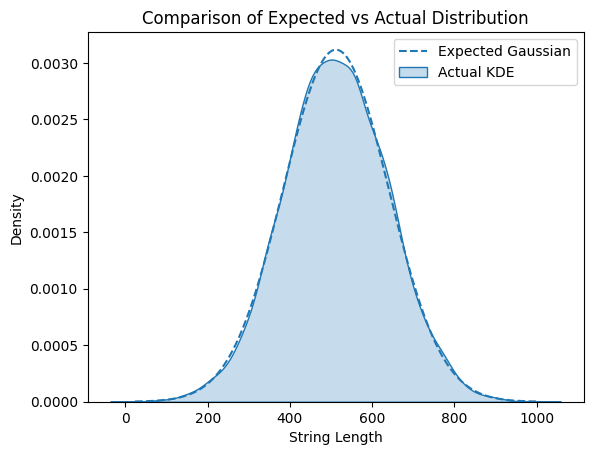

In [56]:
x = np.linspace(min(lengths), max(lengths), 1000)
y = norm.pdf(x, loc=mean_length, scale=std_dev)

plt.plot(x, y, label='Expected Gaussian', linestyle='--')
sns.kdeplot(lengths, fill=True, label='Actual KDE')
plt.legend()
plt.xlabel("String Length")
plt.ylabel("Density")
plt.title("Comparison of Expected vs Actual Distribution")
plt.show()

In [59]:
df = pd.DataFrame(strings)

In [60]:
df

,0
0,zg3xjuiXylMPP3RIk1ocvyabpnqe9YtHeYzI32kXtKXTfI...
1,rIbQbmrh2Y6suJde5PwDrN0NHemVSJzg8ZcI2Fb2RUOPr9...
2,hbtyNfWxMSNZU9ITh23PFiBohfxYpGuUBvkE1SzYYlcyOa...
3,yVcW3qWRI1BIWUUSKQ9nTmMucEYzAnnNzIlUOLLOv5OxE3...
4,zFzTPttnl5ZNKPRhlnXpr817PRSPzcMeirriWtTvxck2B1...
...,...
9995,RL0vEq3AvlX3nNTCSA29fp18XIrA7aiVXdm3CwnRhNHKNO...
9996,1F0DWuWilppkS7Oav92gUnYbMiwDXi2rxbs3OhoTVM8jMk...
9997,MGzNxH3PIh6zM5S9GkPhz9ApfvmOIbLXrfXaVC56BLp4M0...
9998,NGFx6AUkK9xAztTuovwtxG0iXNwlacbnyvMtA5c1LT6i6f...


In [61]:
df.to_csv('Data/Random_strings_10k.txt', index=False, encoding='utf-8')

### for 1k, 10k, 100k, 1M, 10M string

In [62]:
# Parameters
mean_length = 512
std_dev = 128
num_strings = [(1_000, '1K'), (10_000, '10K'), (100_000, '100K'), 
               (1_000_000, '1M'), (10_000_000, '10M')]


for num, label in num_strings:
    # Generate lengths
    lengths = np.random.normal(loc=mean_length, scale=std_dev, size=num).astype(int)
    lengths = np.clip(lengths, a_min=1, a_max=1024)

    # Generate random strings
    def random_string(length):
        return ''.join(random.choices(string.ascii_letters + string.digits, k=length))

    strings = [random_string(length) for length in lengths]

    # Save to file efficiently
    with open(f'Data/Random_strings_{label}.txt', 'w', encoding='utf-8') as f:
        # f.write('Index\tString\n')  # Header
        for i, s in enumerate(strings):
            # f.write(f"{i}\t{s}\n")
            f.write(f"{s}\n")

# Levenshtein Distance

In [77]:
from rapidfuzz.distance import Levenshtein

print(Levenshtein.distance(strings[0], strings[1]))


591


### Calculate ALL leven dist each other

In [ ]:
num_strings = len(strings)
distance_matrix = np.zeros((num_strings, num_strings), dtype=np.int16)

for i in range(num_strings):
    for j in range(i):  # Only compute when i > j
        dist = Levenshtein.distance(strings[i], strings[j])
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist  # Symmetry

# took 10 mins 45 sec


In [84]:
df = pd.DataFrame(distance_matrix)
df.to_csv('Data/All_levenshtein_dist_Random_strings_10k.txt', index=False, sep='\t', encoding='utf-8')

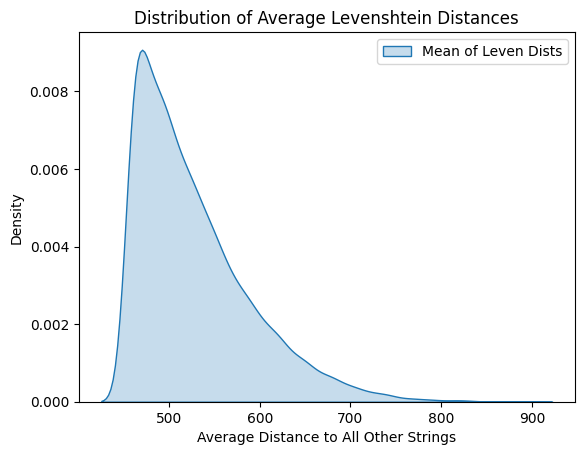

In [85]:
avg_distances = np.mean(distance_matrix, axis=1)

sns.kdeplot(avg_distances, fill=True, label='Mean of Leven Dists')
plt.legend()
plt.xlabel("Average Distance to All Other Strings")
plt.ylabel("Density")
plt.title("Distribution of Average Levenshtein Distances")
plt.show()

# Build indexer

In [24]:
data = pd.read_csv('Data/Random_strings_10k.txt', delimiter='\t', encoding='utf-8')
strings = data['String']

In [25]:
# 
num_strings = len(strings)

# find split num, just in case, make it + 20
# split_num = math.ceil(math.log2(1_000_000))
split_num = 1_000
# 10k 에 대해서 120 보다 커야함 200정도 쓰면 될듯

# make a TF_array that stores TF values
TF_array = np.zeros((num_strings, split_num), dtype=bool)

print(TF_array.shape)

(10000, 1000)


In [34]:
class LevenshteinTree:
    def __init__(self, num_strings, split_num, depth, s1_idx=None, s2_idx=None, tf_array=None):
        self.num_strings = num_strings
        self.split_num = split_num
        self.depth = depth
        self.s1_idx = s1_idx
        self.s2_idx = s2_idx
        self.left = None
        self.right = None

        if tf_array is None and depth == 0:
            self.tf_array = np.zeros((num_strings, split_num), dtype=bool)
        else:
            self.tf_array = tf_array  # share the same array across all nodes

        
    def build_tree(self, strings, indices):
        if self.depth >= self.split_num or len(indices) <= 1:
            return None  # no node needed for empty/terminal group
        
        if len(indices) == 2:
            self.tf_array[indices[0], self.depth] = True
            self.tf_array[indices[1], self.depth] = False
            return LevenshteinTree(self.num_strings, self.split_num, self.depth)    

        rand_pos = np.random.choice(len(indices), size=2, replace=False)  # Randomly pick 2 strings by position
        s1_idx = indices[rand_pos[0]]
        s2_idx = indices[rand_pos[1]]

        node = LevenshteinTree(self.num_strings, self.split_num, self.depth, s1_idx, s2_idx, self.tf_array)

        for idx in indices:
            d1 = Levenshtein.distance(strings[idx], strings[s1_idx])
            d2 = Levenshtein.distance(strings[idx], strings[s2_idx])
            self.tf_array[idx, self.depth] = (d1 >= d2)

        mask = self.tf_array[indices, self.depth]  # Split into left/right efficiently
        left = indices[np.flatnonzero(mask)]
        right = indices[np.flatnonzero(~mask)]

        node.left = LevenshteinTree(self.num_strings, self.split_num, self.depth + 1, tf_array=self.tf_array).build_tree(strings, left)
        node.right = LevenshteinTree(self.num_strings, self.split_num, self.depth + 1, tf_array=self.tf_array).build_tree(strings, right)

        return node
    
        
    def get_code(self, strings, new_str):
        fingerprint = np.zeros(self.split_num, dtype=bool)
        idx = 0
        node = self

        while node and node.s1_idx is not None and node.s2_idx is not None:
            d1 = Levenshtein.distance(new_str, strings[node.s1_idx])
            d2 = Levenshtein.distance(new_str, strings[node.s2_idx])
            go_left = d1 >= d2
            fingerprint[idx] = go_left
            node = node.left if go_left else node.right
            idx += 1

        return fingerprint

    def find_matches(self, strings, new_str, return_strings=True):
        fingerprint = self.get_code(strings, new_str)
        matches = np.where((self.tf_array == fingerprint).all(axis=1))[0]

        if return_strings:
            return matches, [strings[i] for i in matches]
        else:
            return matches

        
    def save_tree(self, filename):
        joblib.dump(self, filename + '.joblib')

    @staticmethod
    def load_tree(filename):
        return joblib.load(filename + '.joblib')

In [35]:
Levenshtein.distance('what is going on', strings[0])

503

### find out proper split_num

In [36]:
tree = LevenshteinTree(num_strings, split_num, depth=0)
tree_root = tree.build_tree(strings, np.arange(num_strings))

In [40]:
code= tree_root.get_code(strings, new_str='hello!')
print(code.shape)
print(code[:5])

(1000,)
[False  True False False  True]


In [42]:
last_true_idx = (np.where(code)[0][-1] if np.any(code) else 0)
print(last_true_idx)

97


In [44]:
last_trues = np.zeros((num_strings,), dtype=np.int16)
for i, x in enumerate(strings):
    code = tree_root.get_code(strings,x)
    last_true_idx = (np.where(code)[0][-1] if np.any(code) else 0)
    last_trues[i] = last_true_idx


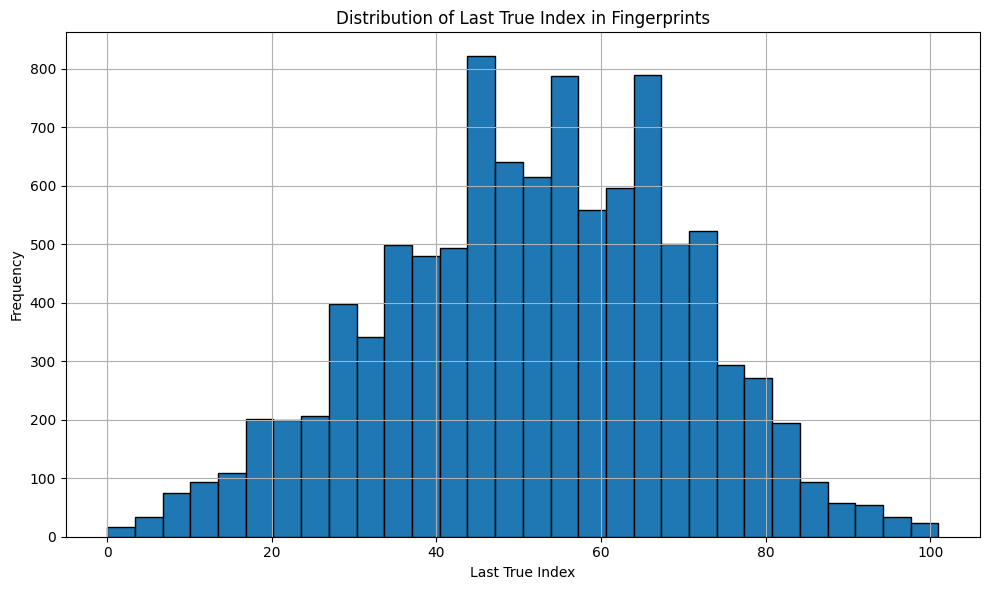

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(last_trues, bins=30, edgecolor='black')
plt.title("Distribution of Last True Index in Fingerprints")
plt.xlabel("Last True Index")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


### build 100 trees

In [ ]:
trees = []
for i in range(100):
    tree_root = recursive_split(np.arange(num_strings), 0, TF_array, split_num)
    trees.append(tree_root)

# took 22 min 49.8 sec

In [ ]:
possible_answers = []
for tree_root in trees:
    fp = fingerprint_string("what is going on", tree_root, split_num)
    # print(fp.shape)
    # print(fp)
    matches = np.where((TF_array == fp).all(axis=1))
    print(matches)
    answer = strings[matches]
    possible_answers.append(answer)
    break

    

(1000,)
[False False  True  True  True False False  True False False False  True
  True False False False False False  True False  True False  True False
  True False  True False False  True False False  True False False  True
  True  True  True  True False  True False False  True  True False False
  True  True  True  True  True False  True False False False  True  True
 False False False False  True  True  True False  True  True  True False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

KeyError: 'key of type tuple not found and not a MultiIndex'